# Model evaluation using Sidekick
In this notebook you will learn how to use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [1]:
from IPython.display import display, Image
import os
import operator
import sidekick
import resource
import itertools
import pandas as pd
from PIL import Image

## Setup

### Path to preprocessed dataset

In [4]:
dataset_path = './preprocessed'

### Platform deployment

In [5]:
deploy_url = 'https://...'
deploy_token = '...'

### Helper functions

In [18]:
def get_max_score(pred):
    max_key = 'None'
    max_score = 0
    dict = pred['class'].items()
    for key,score in dict:
        if score >= max_score:        
            max_key = key
            max_score = score
    return (max_key, max_score)

def get_image(path):
    im = Image.open(os.path.join(dataset_path, path))
    new_im = im.copy()
    new_im.format = 'jpeg'
    im.close()
    return new_im

## Getting single  predictions

### Deployment

In [8]:
client = sidekick.Deployment(
    # Enter URL and token
    url=deploy_url,
    token=deploy_token,
    dtypes_in={'image': 'Image (224x224x3)'},
    dtypes_out={'class': 'Categorical (8)'}
)

### Ground truth

In [10]:
df = pd.read_csv(os.path.join(dataset_path, 'index.csv'))
df = df.sample(frac=1, random_state=2323)
df.head()

,image,class,subset
370,image/370.jpeg,unknown,T
1446,image/1446.jpeg,tail_lamp,V
173,image/173.jpeg,door_scratch,T
621,image/621.jpeg,glass_shatter,T
1358,image/1358.jpeg,bumper_dent,V


### Predict damage for one image

In [11]:
im_path_list = iter(list(df['image']))

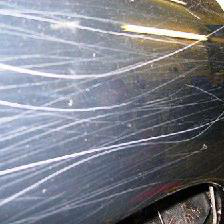

('door_scratch', 0.7929398)


In [14]:
im_path = next(im_path_list)
im = Image.open(os.path.join(dataset_path, im_path))
display(im)
pred = client.predict(image=im)
print(get_max_score(pred))

### Predict damage for multiple images

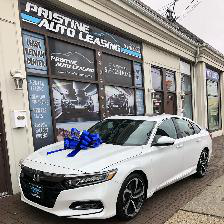

Ground truth: unknown
Prediction: {'bumper_scratch': 3.9388723e-07, 'head_lamp': 1.5897404e-05, 'door_scratch': 1.7123214e-06, 'glass_shatter': 0.0002390386, 'bumper_dent': 4.1369844e-08, 'door_dent': 1.5598836e-06, 'tail_lamp': 2.9467754e-05, 'unknown': 0.9997118}


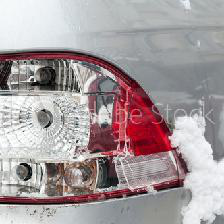

Ground truth: tail_lamp
Prediction: {'bumper_scratch': 6.714796e-05, 'head_lamp': 0.16924721, 'door_scratch': 1.1321491e-06, 'glass_shatter': 0.043952398, 'bumper_dent': 7.455617e-05, 'door_dent': 1.6957007e-06, 'tail_lamp': 0.77497184, 'unknown': 0.011684106}


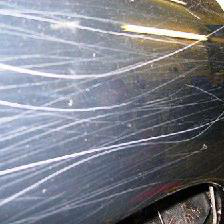

Ground truth: door_scratch
Prediction: {'bumper_scratch': 0.082763955, 'head_lamp': 0.0018532092, 'door_scratch': 0.7929398, 'glass_shatter': 0.016729133, 'bumper_dent': 0.0004978096, 'door_dent': 0.10017018, 'tail_lamp': 0.0002912063, 'unknown': 0.0047547873}


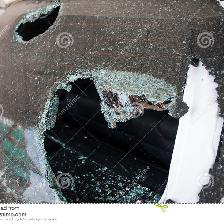

Ground truth: glass_shatter
Prediction: {'bumper_scratch': 5.200249e-05, 'head_lamp': 0.0007140636, 'door_scratch': 5.4847376e-05, 'glass_shatter': 0.9730757, 'bumper_dent': 0.0008146079, 'door_dent': 1.2078961e-05, 'tail_lamp': 0.0010116948, 'unknown': 0.024264911}


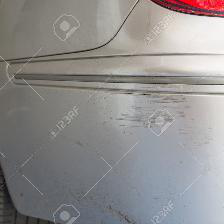

Ground truth: bumper_dent
Prediction: {'bumper_scratch': 0.63891184, 'head_lamp': 0.0003109448, 'door_scratch': 0.100268945, 'glass_shatter': 0.00078471075, 'bumper_dent': 0.13126001, 'door_dent': 0.12507753, 'tail_lamp': 0.00056238903, 'unknown': 0.0028236387}


In [15]:
first_rows = df.head()
for i, row in first_rows.iterrows():
    img = Image.open(os.path.join(dataset_path, row['image']))
    display(img)
    pred = client.predict(image=img)
    print('Ground truth: {}\nPrediction: {}'.format(row['class'], pred['class']))

## Getting predictions (batch)

### Filter out training data
The predictions on the evaluation subset will be used in the analysis of the deployed model.

In [16]:
# Validation data
eval_df = df[df['subset']=='V'].copy()

### Batch request

In [19]:
eval_df['image_url'] = eval_df['image']
eval_df['image'] = eval_df['image'].apply(lambda path: get_image(path))
predictions = client.predict_lazy(eval_df.to_dict('record'))
eval_df.head(1)

,image,class,subset,image_url
1446,<PIL.Image.Image image mode=RGB size=224x224 a...,tail_lamp,V,image/1446.jpeg


In [20]:
#This may take several minutes...
preds = [p for p in predictions]
eval_df['pred'] = [p['class'] for p in preds]
eval_df.head(5)

,image,class,subset,image_url,pred
1446,<PIL.Image.Image image mode=RGB size=224x224 a...,tail_lamp,V,image/1446.jpeg,"{'bumper_scratch': 6.7147936e-05, 'head_lamp':..."
1358,<PIL.Image.Image image mode=RGB size=224x224 a...,bumper_dent,V,image/1358.jpeg,"{'bumper_scratch': 0.63891184, 'head_lamp': 0...."
1308,<PIL.Image.Image image mode=RGB size=224x224 a...,bumper_scratch,V,image/1308.jpeg,"{'bumper_scratch': 0.6181019, 'head_lamp': 0.2..."
1323,<PIL.Image.Image image mode=RGB size=224x224 a...,door_scratch,V,image/1323.jpeg,"{'bumper_scratch': 0.00083989365, 'head_lamp':..."
1383,<PIL.Image.Image image mode=RGB size=224x224 a...,unknown,V,image/1383.jpeg,"{'bumper_scratch': 8.8179695e-05, 'head_lamp':..."


## Evaluation

In [21]:
dicts = eval_df['pred']
max_keys = []
max_scores = []

for i in dicts:
    max_val = max(i.items(), key=lambda k: k[1])     
    max_keys.append(max_val[0])
    max_scores.append(max_val[1])
eval_df['pred_class'] = max_keys
eval_df['pred_score'] = max_scores
eval_df.head(5)

,image,class,subset,image_url,pred,pred_class,pred_score
1446,<PIL.Image.Image image mode=RGB size=224x224 a...,tail_lamp,V,image/1446.jpeg,"{'bumper_scratch': 6.7147936e-05, 'head_lamp':...",tail_lamp,0.774972
1358,<PIL.Image.Image image mode=RGB size=224x224 a...,bumper_dent,V,image/1358.jpeg,"{'bumper_scratch': 0.63891184, 'head_lamp': 0....",bumper_scratch,0.638912
1308,<PIL.Image.Image image mode=RGB size=224x224 a...,bumper_scratch,V,image/1308.jpeg,"{'bumper_scratch': 0.6181019, 'head_lamp': 0.2...",bumper_scratch,0.618102
1323,<PIL.Image.Image image mode=RGB size=224x224 a...,door_scratch,V,image/1323.jpeg,"{'bumper_scratch': 0.00083989365, 'head_lamp':...",door_dent,0.801941
1383,<PIL.Image.Image image mode=RGB size=224x224 a...,unknown,V,image/1383.jpeg,"{'bumper_scratch': 8.8179695e-05, 'head_lamp':...",unknown,0.983533


### Worst misclassified examples

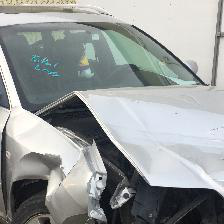

Ground truth: unknown, Prediction: glass_shatter, Score: 0.9919133


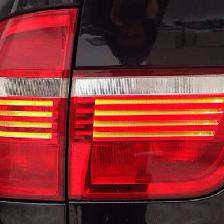

Ground truth: unknown, Prediction: tail_lamp, Score: 0.9894248


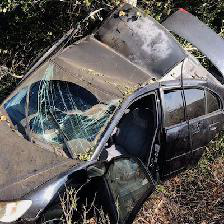

Ground truth: unknown, Prediction: glass_shatter, Score: 0.9844818


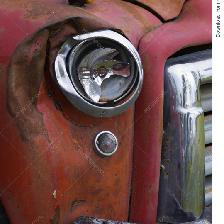

Ground truth: head_lamp, Prediction: unknown, Score: 0.96625173


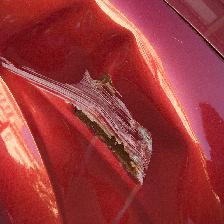

Ground truth: door_dent, Prediction: glass_shatter, Score: 0.95978737


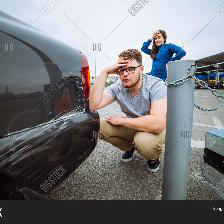

Ground truth: door_scratch, Prediction: bumper_scratch, Score: 0.90069485


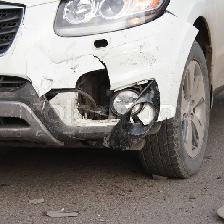

Ground truth: head_lamp, Prediction: bumper_dent, Score: 0.89575857


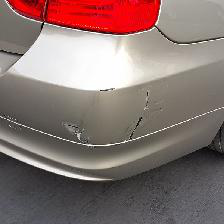

Ground truth: bumper_scratch, Prediction: bumper_dent, Score: 0.894048


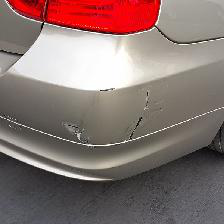

Ground truth: bumper_scratch, Prediction: bumper_dent, Score: 0.894048


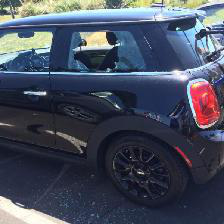

Ground truth: glass_shatter, Prediction: unknown, Score: 0.89148223


In [22]:
wrong_df = eval_df.loc[eval_df['class'] != eval_df['pred_class']]
wrong_df = wrong_df.sort_values(by=['pred_score'], ascending=False)
first_rows = wrong_df.head(10)
for i, row in first_rows.iterrows():
    display(row['image'])
    print('Ground truth: {}, Prediction: {}, Score: {}'.format(row['class'], row['pred_class'], row['pred_score']))